## Using AIRMA to predict Closing Stock price

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

Load the dataset: TSLA we be looking at time period 2014-2024

In [32]:
# Load the data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
TSLA='TSLA.csv'
df = pd.read_csv(TSLA,index_col = 'Date',parse_dates = True)

In [33]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-05-27,13.901333,14.258000,13.846667,14.104000,14.104000,80116500
2014-05-28,14.001333,14.184667,13.684000,14.016000,14.016000,82426500
2014-05-29,14.038000,14.166000,13.848000,14.016000,14.016000,55387500
2014-05-30,14.020000,14.320000,13.801333,13.851333,13.851333,83716500
2014-06-02,13.822000,13.956667,13.444667,13.646667,13.646667,70021500


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2014-05-27 to 2024-05-24
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2518 non-null   float64
 1   High       2518 non-null   float64
 2   Low        2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Adj Close  2518 non-null   float64
 5   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


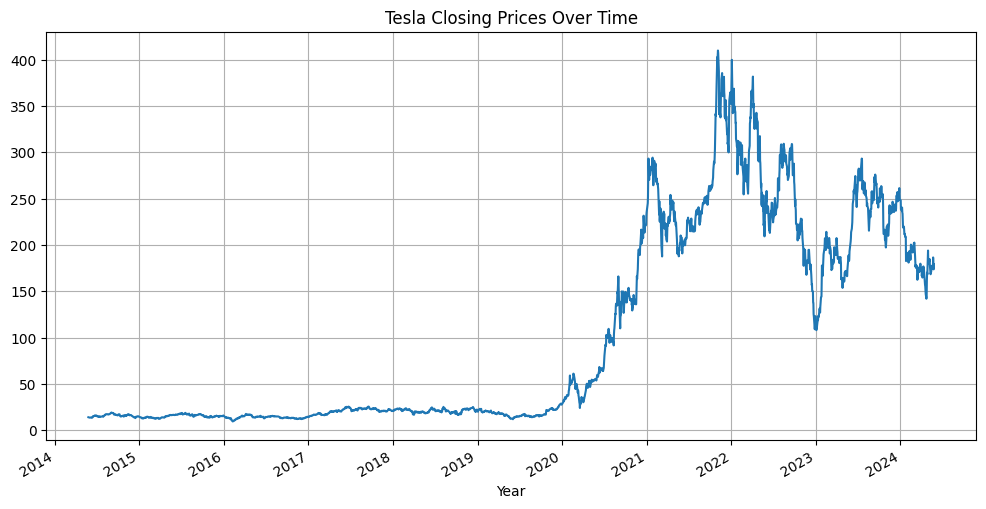

In [35]:
#plt.style.use('default')
plt.figure(figsize=(12,6))
df['Close'].plot()
plt.grid(True)
plt.title("Tesla Closing Prices Over Time")
plt.xlabel("Year")
plt.show()

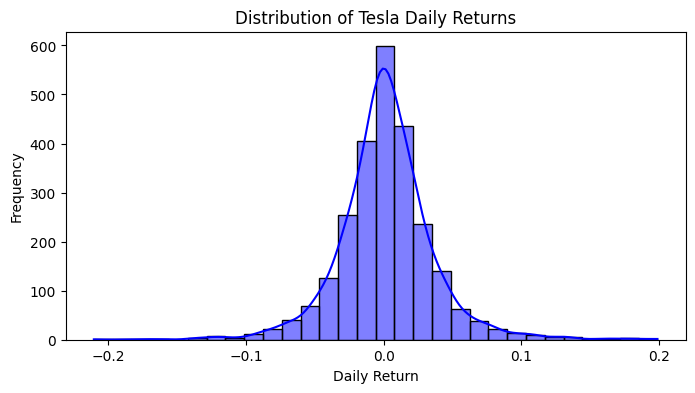

In [36]:
# Distribution of Daily Returns
plt.figure(figsize=(8, 4))
sns.histplot(df['Adj Close'].pct_change().dropna(), bins=30, kde=True, color='blue')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Daily Return')
plt.ylabel('Frequency')
plt.show()

What is volatility in finance
Volatility in finance refers to the amount of fluctuation or variability in the price of a stock
volatility of a stock or asset is often assumed to follow a normal distribution, also known as a bell curve. 
This means that most price fluctuations will fall within a certain range, with extreme price movements being less likely.

As seen above Tesla's distribution of daily returns follows a normal distribution


Reference: https://www.physicsforums.com/threads/finance-does-the-volatility-of-a-stock-follow-a-certain-distribution.1011873/

## Stationarity
Stationarity means that it will not exibit any long term trends or obvious seasonality<br> 
if a time series is said to be stationary it will have : 
*    A constant variance through time
*    A constant mean through time

**Is Tesla closing price over time series Stationary?**<br>

At first glance, visually: No.  After 2020 there is a clear increase in trend along with flactuating values<br>
Mathematically, ADF (Augmented Dickey-Fuller) Test can be used to determine if the series is stationary 

**ADF (Augmented Dickey-Fuller) Test**

The Dickey-Fuller test can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary,<br> 
The null and alternate hypothesis of this test is:
Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary

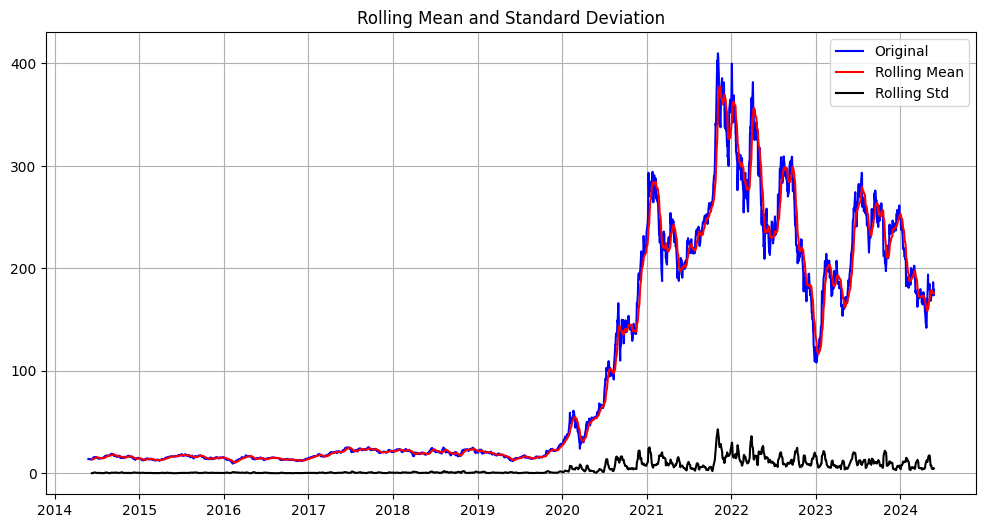

Results of dickey fuller test
Test Statistics                  -1.359154
p-value                           0.601694
No. of lags used                 27.000000
Number of observations used    2490.000000
critical value (1%)              -3.432979
critical value (5%)              -2.862701
critical value (10%)             -2.567388
dtype: float64


In [37]:
#Test for staionarity
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.figure(figsize=(12,6))
    plt.grid(True)
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df['Close'])

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.
*    We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis.<br>
*    The absolute value of -1.359154 is relatively low compared to the critical values, suggesting that the time series is not stationary.

## Eliminate Trend and Seasonality
In order to perform a time series analysis, it is recommended to have a stationary time series. <br>
The reason is to ensure the statistical properties like mean and standard variance, this is important when training the data <br>

So that the forecast is treated as a random variable that belongs to the same distribution as the training data, basically guarantees the data in the future will be somewhat like the past. 

<Figure size 640x480 with 0 Axes>

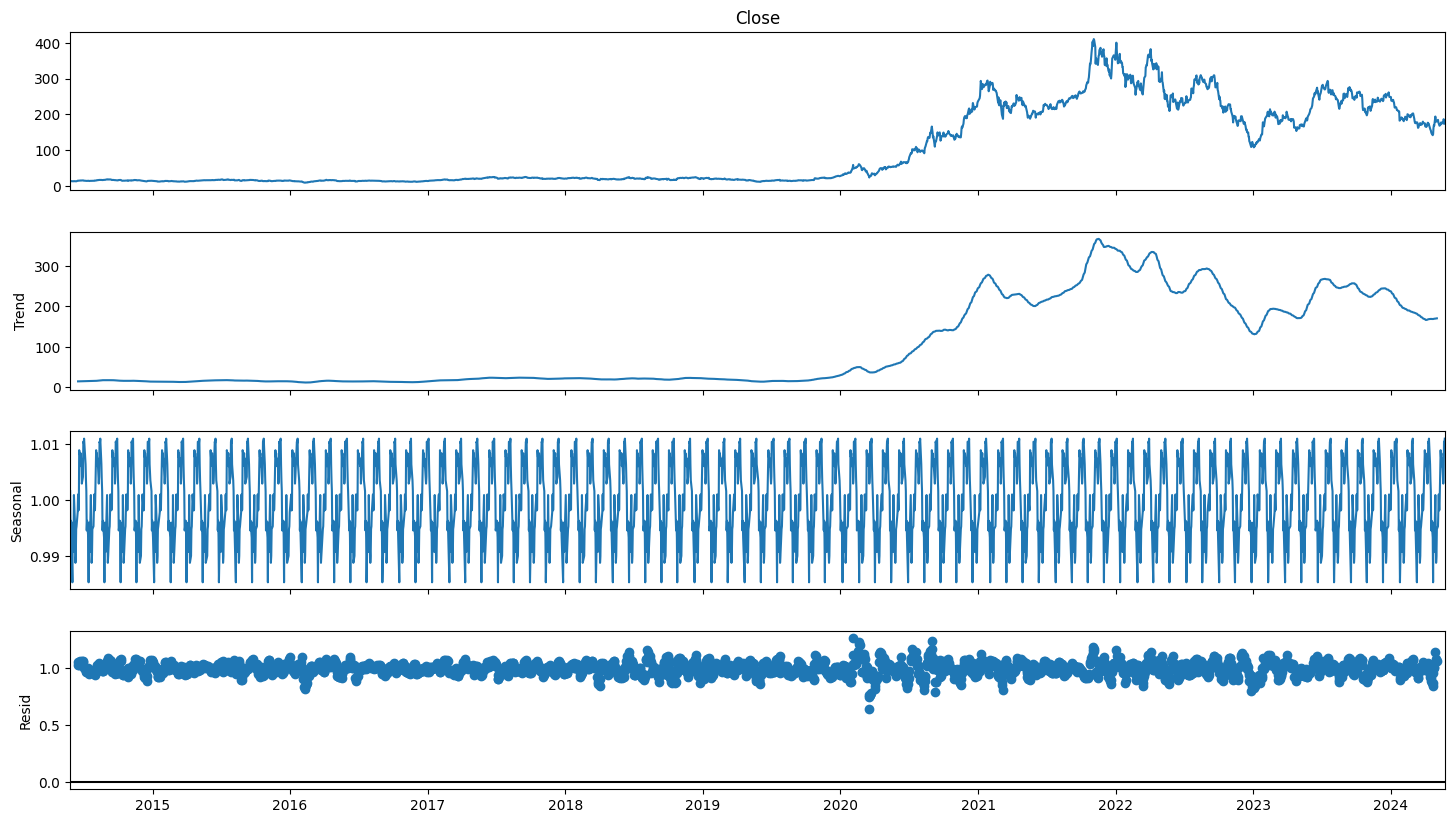

In [38]:
#To separate the trend and the seasonality from a time series, 
# we can decompose the series using the following code.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

## Logarithm Transformation

take a log of the series to reduce the magnitude of the values and reduce the rising trend in the series<br>
Find the rolling average of the time series<br>
The rolling average here is calculated by taking input for the past 12 months and giving a mean 

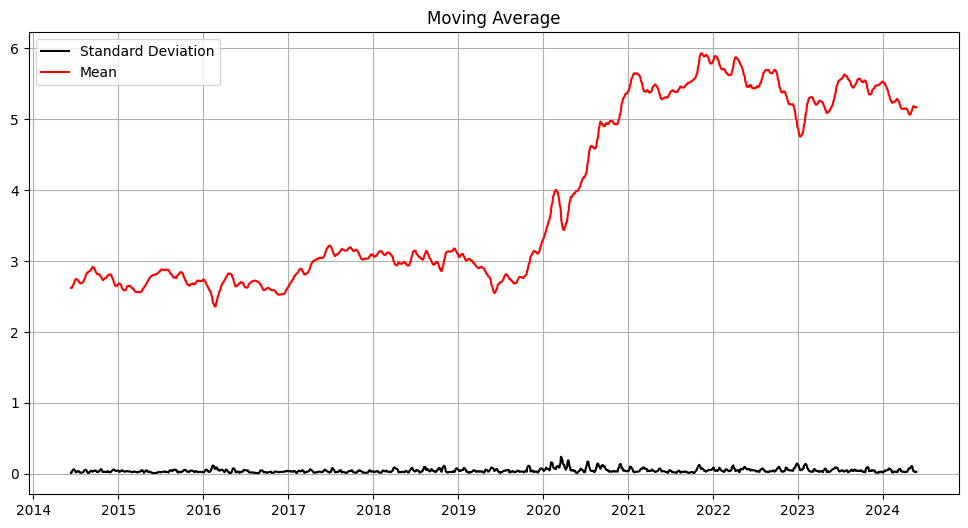

In [39]:
df_log = np.log(df['Close'])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.figure(figsize=(12,6))
plt.grid(True)
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

## Auto-Regressive Integrated Moving Average (ARIMA)



### Split the data into train and test<br>
90% train and 10% test



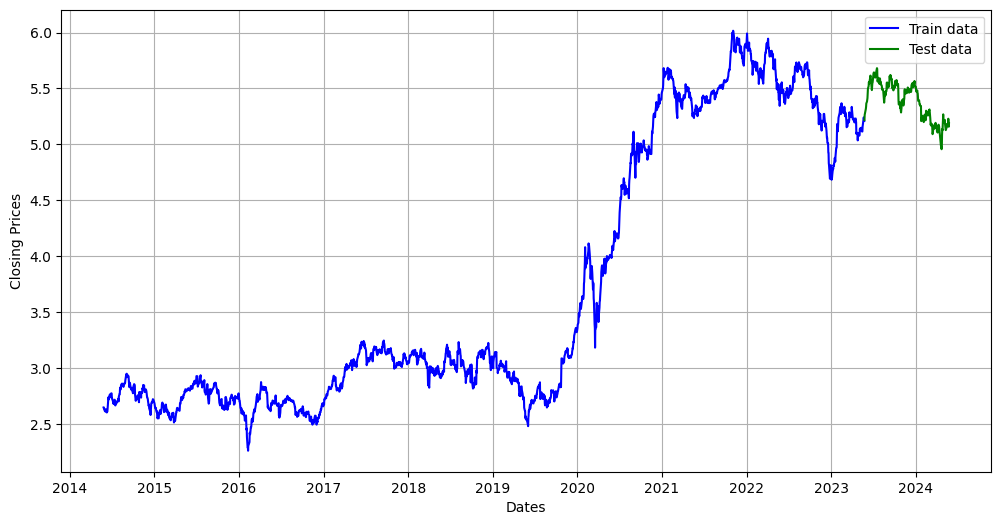

In [40]:
from statsmodels.tsa.arima.model import ARIMA
train_size = int(len(df_log) * 0.9)
train_data, test_data = df_log.iloc[:train_size], df_log.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_data, 'blue', label='Train data')
plt.plot(test_data, 'green', label='Test data')
plt.legend()

## Auto ARIMA
The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. based on the commonly-used R function, forecast::auto.arima.

The auto_arima function works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto_arima also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D.

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-8726.384, Time=0.32 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-8724.751, Time=0.40 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-8724.724, Time=0.38 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-8726.048, Time=0.18 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-8722.430, Time=0.86 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 2.255 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2266
Model:               SARIMAX(0, 1, 0)   Log Likelihood                4365.192
Date:                Sat, 08 Jun 2024   AIC                          -8726.384
Time:                        13:09:59   BIC                          -8714.933
Sample:                             0   HQIC                         -8722.206
                               - 2266                                  

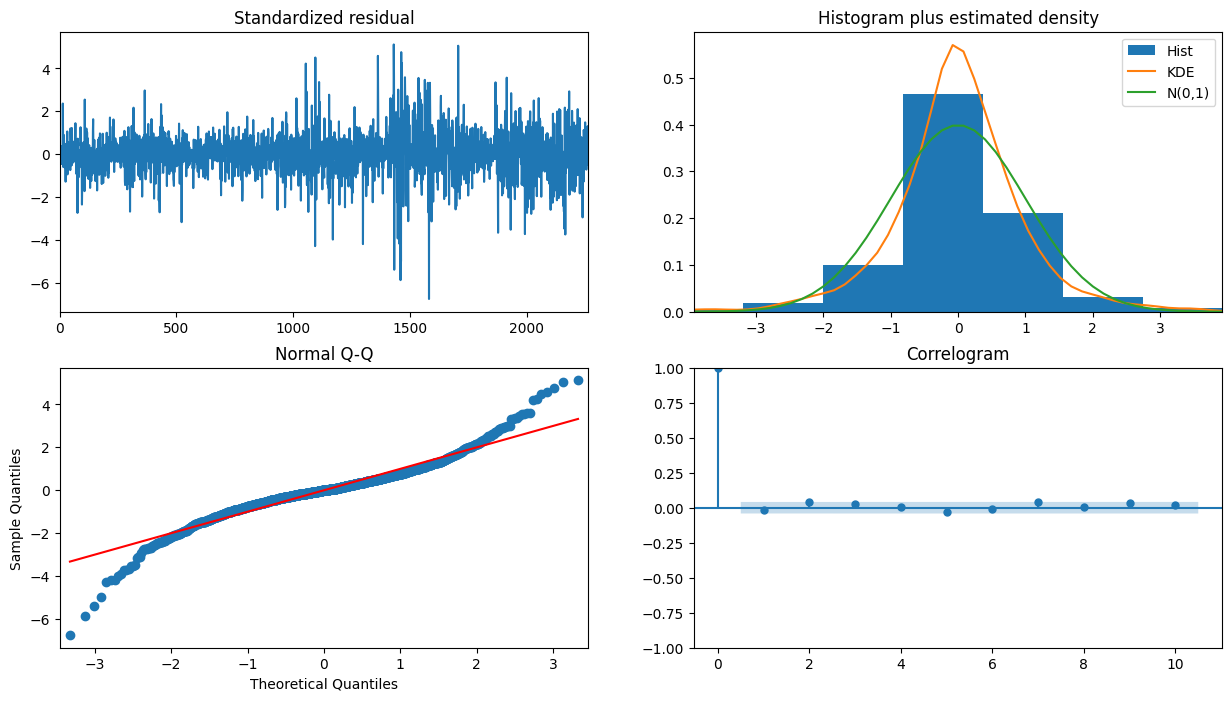

In [82]:
from pmdarima import auto_arima
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

**Diagnostics Plots**
*    Standardized Residuals: The residuals (differences between the observed and fitted values) standardized by their standard deviation. Ideally, these should look like white noise (i.e., no patterns).

*    Histogram plus estimated density: The histogram of the residuals with the overlaid density estimates (KDE) and a normal distribution for comparison. This helps assess the normality of residuals.

*    Normal Q-Q Plot: Compares the quantiles of the residuals with the theoretical quantiles of a normal distribution. If the residuals are normally distributed, the points should lie on the red line.*  

*    Correlogram: The autocorrelation function (ACF) of the residuals. Significant autocorrelations would suggest model inadequacy. Ideally, all points should lie within the confidence bounds indicating no significant autocorrelation.

**The chosen model is ARIMA(0,1,0) with an intercept. So the value of p,d, and q as 0 , 1 and 0 respectively.** <br>
This is essentially a random walk with a drift model, indicating that the series is differenced once to achieve stationarity and does not have autoregressive (AR) or moving average (MA) components.

The model diagnostics suggest that the residuals are approximately normally distributed and do not exhibit significant autocorrelation, indicating a good fit.
 

In [50]:
# Build Model
import warnings
warnings.filterwarnings("ignore")
model = ARIMA(train_data, order=(0,1,0))  
fitted = model.fit()  
print(fitted.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2266
Model:                 ARIMA(0, 1, 0)   Log Likelihood                4364.024
Date:                Sat, 08 Jun 2024   AIC                          -8726.048
Time:                        10:28:45   BIC                          -8720.322
Sample:                             0   HQIC                         -8723.958
                               - 2266                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0012   2.02e-05     61.424      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):              2084.35
Prob(Q):                              0.54   Pr

Forecast the stock prices on the test dataset keeping 95% confidence level.

In [95]:
# Forecast
n_periods = 90
fc = fitted.forecast(n_periods, alpha=0.05)
#std error
se = fitted.forecast(n_periods, alpha=0.05)
#conficendce interval
conf = fitted.forecast(n_periods, alpha=0.05)

### Plot the prediction

NameError: name 'lower_series' is not defined

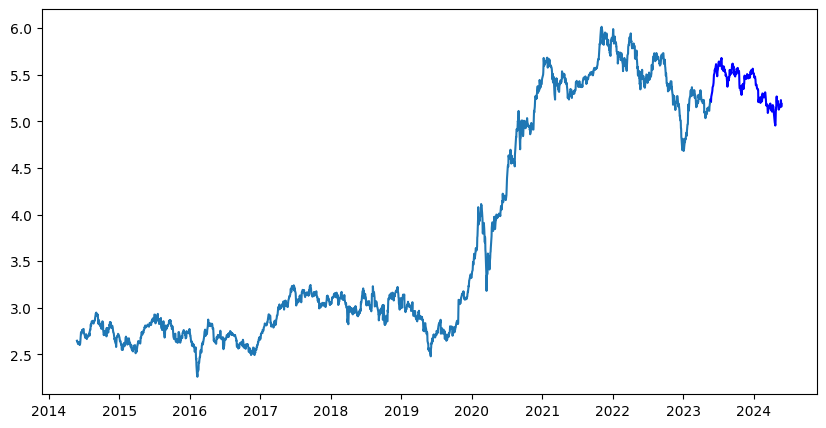

In [99]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert forecasts to a pandas Series
fc_series = pd.Series(fc, index=test_data.index[-90:])
# Ensure conf is a 2D NumPy array
#if isinstance(conf, np.ndarray) and len(conf.shape) == 2:
    # Correctly unpack conf into lower_series and upper_series
    #lower_series = pd.Series(conf[:, 0], index=test_data.index[-90:])
    #upper_series = pd.Series(conf[:, 1], index=test_data.index[-90:])
#else:
    #raise ValueError("Expected conf to be a 2D NumPy array")

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('TSLA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('TSLA Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()